# Imports

In [1]:
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import itertools

# imports for data visualisation
import seaborn as sns
from PIL import Image
from scipy import stats
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
#!pip install wordcloud
from wordcloud import WordCloud, ImageColorGenerator
%matplotlib inline

# imports for pre-processing
import os
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
import string
import nltk

#
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# classification models
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#!pip install scikit-plot
from scikitplot.metrics import plot_roc, plot_confusion_matrix # pip install scikit-plot

# Loading the data

In [2]:
#Reading in the data
df_train = pd.read_csv('train_set.csv')
df_test = pd.read_csv('test_set.csv')

In [3]:
df_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [4]:
df_test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


In [5]:
df_train.shape

(33000, 2)

In [6]:
#Checking data type 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


In [7]:
#Checking nulls
df_train.isnull().sum()

lang_id    0
text       0
dtype: int64

# Data pre-processing/cleaning

# Tokenisation

In [8]:
def tokenize_text(df):
    # tokenizing the text
   
    cleaned_text = df["text"].apply(lambda x: word_tokenize(x))

    # removing punctuation
    cleaned_text = cleaned_text.apply(lambda x : [token for token in x if token not in string.punctuation])

    # removing digits 
    cleaned_text = cleaned_text.apply(lambda x: [token for token in x if token not in list(string.digits)])

    # removing all one character tokens
    cleaned_text = cleaned_text.apply(lambda x: [token for token in x if len(token) > 1])
    
    df["tokenized_text"] = cleaned_text
    
    return df["tokenized_text"]

In [9]:
tokenize_text(df_train).head()

0    [umgaqo-siseko, wenza, amalungiselelo, kumazik...
1    [i-dha, iya, kuba, nobulumko, bokubeka, umsebe...
2    [the, province, of, kwazulu-natal, department,...
3    [netefatša, gore, ba, file, dilo, ka, moka, tš...
4    [khomishini, ya, ndinganyiso, ya, mbeu, yo, ew...
Name: tokenized_text, dtype: object

In [10]:
tokenize_text(df_test).head()

0    [Mmasepala, fa, maemo, kgethegileng, letlelela...
1    [Uzakwaziswa, ngokufaneleko, nakungafuneka, em...
2    [Tshivhumbeo, tshi, fana, na, ngano, dza, vhathu]
3    [Kube, inja, nelikati, betingevakala, kutsi, t...
4                    [Winste, op, buitelandse, valuta]
Name: tokenized_text, dtype: object

# Stopwords

In [11]:
!pip install stopwordsiso
from stopwordsiso import stopwords

# Get stopwords for all South African languages
sa_languages = ["zu", "tn", "af", "en", 'nso', 'st', "tn", "ts", "ss", "ve", "xh"]  
stopwords_sa = stopwords(sa_languages)


# Convert to lower case
df_train["tokenized_text"] = df_train["tokenized_text"].apply(lambda x: [word.lower() for word in x])

# Remove stopwords
df_train["no_stopwords"] = df_train["tokenized_text"].apply(lambda x: [item for item in x if item not in stopwords_sa])

df_train.head()

,lang_id,text,tokenized_text,no_stopwords
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,"[umgaqo-siseko, wenza, amalungiselelo, kumazik...","[umgaqo-siseko, wenza, amalungiselelo, kumazik..."
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,"[i-dha, iya, kuba, nobulumko, bokubeka, umsebe...","[i-dha, iya, kuba, nobulumko, bokubeka, umsebe..."
2,eng,the province of kwazulu-natal department of tr...,"[the, province, of, kwazulu-natal, department,...","[province, kwazulu-natal, department, transpor..."
3,nso,o netefatša gore o ba file dilo ka moka tše le...,"[netefatša, gore, ba, file, dilo, ka, moka, tš...","[netefatša, gore, file, dilo, moka, tše, dumel..."
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,"[khomishini, ya, ndinganyiso, ya, mbeu, yo, ew...","[khomishini, ya, ndinganyiso, ya, mbeu, yo, ew..."


In [12]:
#Applying same to test data

df_test["tokenized_text"] = df_test["tokenized_text"].apply(lambda x: [word.lower() for word in x])

# Remove stopwords
df_test["no_stopwords"] = df_test["tokenized_text"].apply(lambda x: [item for item in x if item not in stopwords_sa])

df_test.head()

,index,text,tokenized_text,no_stopwords
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele...","[mmasepala, fa, maemo, kgethegileng, letlelela...","[mmasepala, fa, maemo, kgethegileng, letlelela..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...,"[uzakwaziswa, ngokufaneleko, nakungafuneka, em...","[uzakwaziswa, ngokufaneleko, nakungafuneka, em..."
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.,"[tshivhumbeo, tshi, fana, na, ngano, dza, vhathu]","[tshivhumbeo, tshi, fana, ngano, dza, vhathu]"
3,4,Kube inja nelikati betingevakala kutsi titsini...,"[kube, inja, nelikati, betingevakala, kutsi, t...","[kube, inja, nelikati, betingevakala, kutsi, t..."
4,5,Winste op buitelandse valuta.,"[winste, op, buitelandse, valuta]","[winste, buitelandse, valuta]"


# Mapping languages

In [13]:
df_train["language"] = df_train["lang_id"].map({'xho': "isiXhosa", 'eng': "English", 'nso': "Sepedi", 'ven': "Tshivenda",
                                                'nbl': 'isiNdebele', 'afr': 'Afrikaans','sot':'Sesotho', 'ssw':'siSwati',
                                              'tsn': 'Setswana', 'tso': 'Xitsonga', 'zul': 'isiZulu' })
df_train.head()

,lang_id,text,tokenized_text,no_stopwords,language
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,"[umgaqo-siseko, wenza, amalungiselelo, kumazik...","[umgaqo-siseko, wenza, amalungiselelo, kumazik...",isiXhosa
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,"[i-dha, iya, kuba, nobulumko, bokubeka, umsebe...","[i-dha, iya, kuba, nobulumko, bokubeka, umsebe...",isiXhosa
2,eng,the province of kwazulu-natal department of tr...,"[the, province, of, kwazulu-natal, department,...","[province, kwazulu-natal, department, transpor...",English
3,nso,o netefatša gore o ba file dilo ka moka tše le...,"[netefatša, gore, ba, file, dilo, ka, moka, tš...","[netefatša, gore, file, dilo, moka, tše, dumel...",Sepedi
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,"[khomishini, ya, ndinganyiso, ya, mbeu, yo, ew...","[khomishini, ya, ndinganyiso, ya, mbeu, yo, ew...",Tshivenda


# Exploratory data analysis

In [14]:
df_eda = df_train.copy()
df_eda.head()

,lang_id,text,tokenized_text,no_stopwords,language
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,"[umgaqo-siseko, wenza, amalungiselelo, kumazik...","[umgaqo-siseko, wenza, amalungiselelo, kumazik...",isiXhosa
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,"[i-dha, iya, kuba, nobulumko, bokubeka, umsebe...","[i-dha, iya, kuba, nobulumko, bokubeka, umsebe...",isiXhosa
2,eng,the province of kwazulu-natal department of tr...,"[the, province, of, kwazulu-natal, department,...","[province, kwazulu-natal, department, transpor...",English
3,nso,o netefatša gore o ba file dilo ka moka tše le...,"[netefatša, gore, ba, file, dilo, ka, moka, tš...","[netefatša, gore, file, dilo, moka, tše, dumel...",Sepedi
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,"[khomishini, ya, ndinganyiso, ya, mbeu, yo, ew...","[khomishini, ya, ndinganyiso, ya, mbeu, yo, ew...",Tshivenda


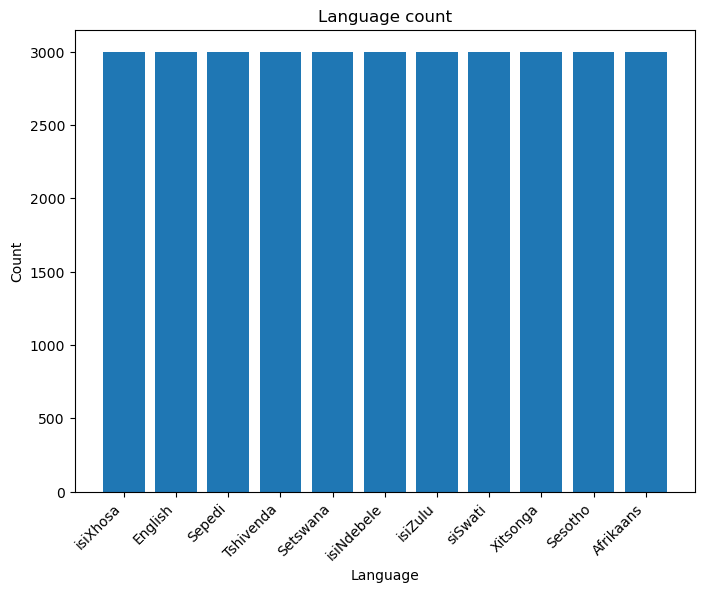

In [15]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the bar chart
languages = df_eda['language'].unique()
language_counts = df_eda['language'].value_counts()
ax.bar(languages, language_counts)

# Rotate x-labels
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Language count')

# Adjust figure size
fig.set_size_inches(8, 6)

# Display the plot
plt.show()

In [16]:
language_counts = df_eda['language'].value_counts()

# Print the language counts
print(language_counts)

isiXhosa      3000
English       3000
Sepedi        3000
Tshivenda     3000
Setswana      3000
isiNdebele    3000
isiZulu       3000
siSwati       3000
Xitsonga      3000
Sesotho       3000
Afrikaans     3000
Name: language, dtype: int64


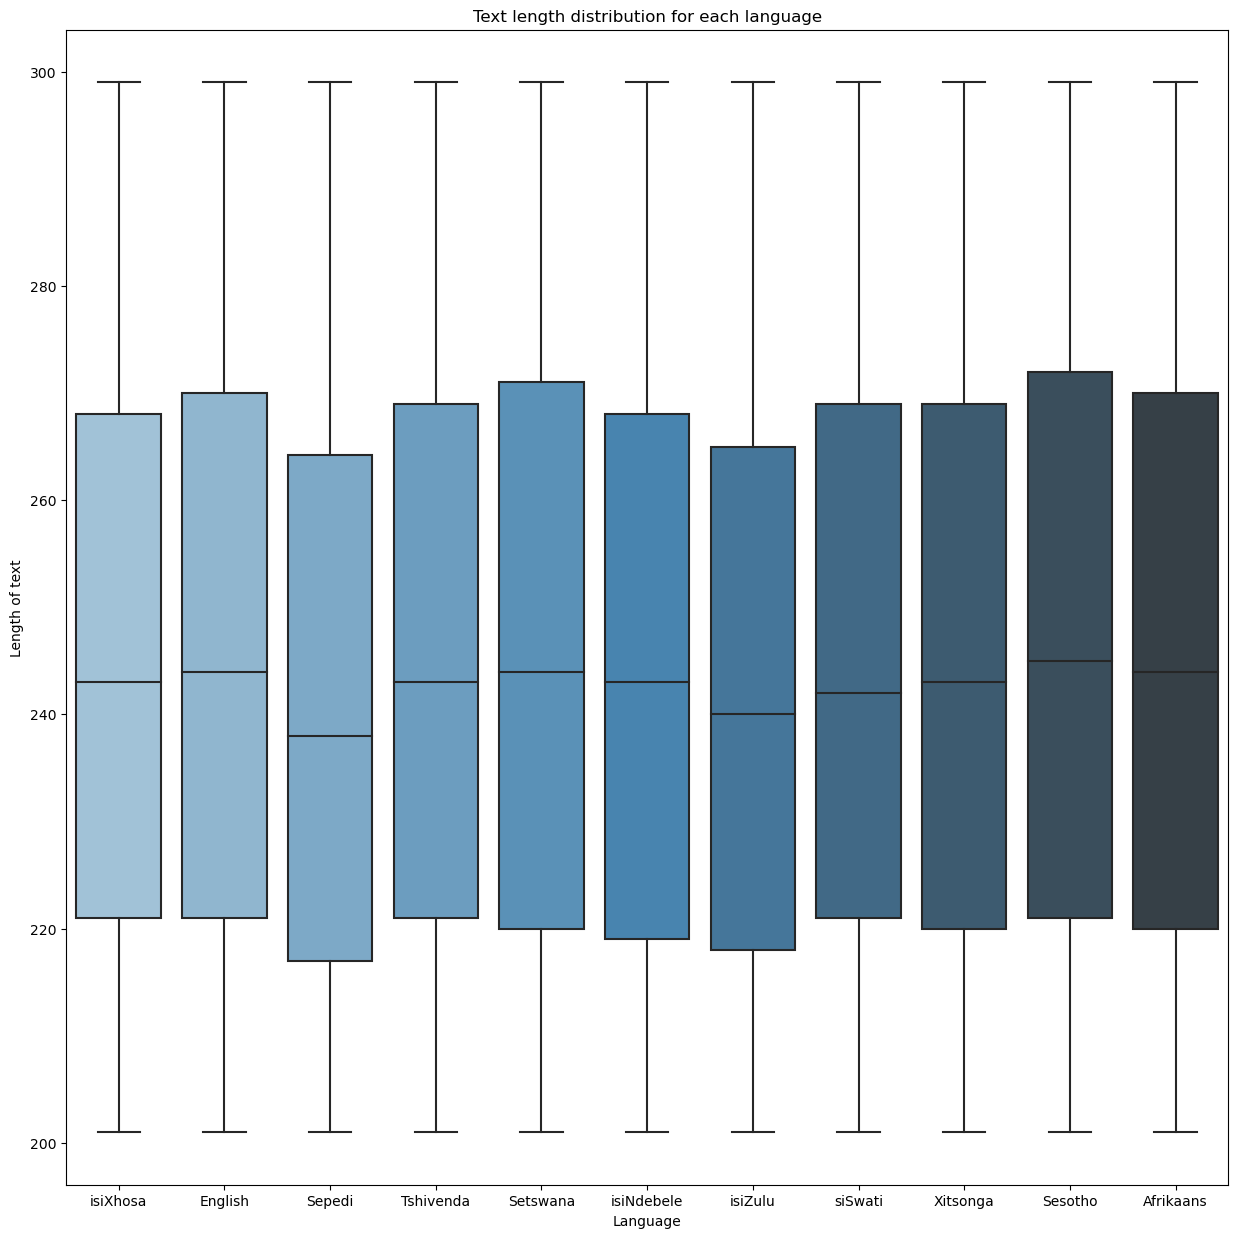

In [17]:
plt.figure(figsize=(15, 15))
sns.boxplot(x="language", y=df_eda['text'].apply(len), data=df_eda, palette=("Blues_d"))
plt.title("Text length distribution for each language")

# Adding labels 
plt.xlabel('Language')
plt.ylabel('Length of text')

plt.show()
fig.savefig('boxplot.png')

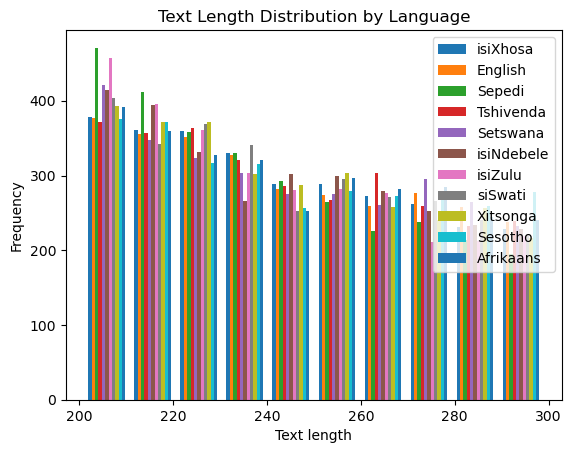

In [18]:


# Calculate the length of the text for each language
df_eda['text_length'] = df_eda['text'].apply(lambda x: len(x))

# Plot histograms
plt.hist([df_eda[df_eda['language'] == lang]['text_length'] for lang in df_eda['language'].unique()],
         bins=10,
         label=df_eda['language'].unique())

# Add labels and title
plt.xlabel('Text length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution by Language')

# Add legend
plt.legend()

# Display the plot
plt.show()

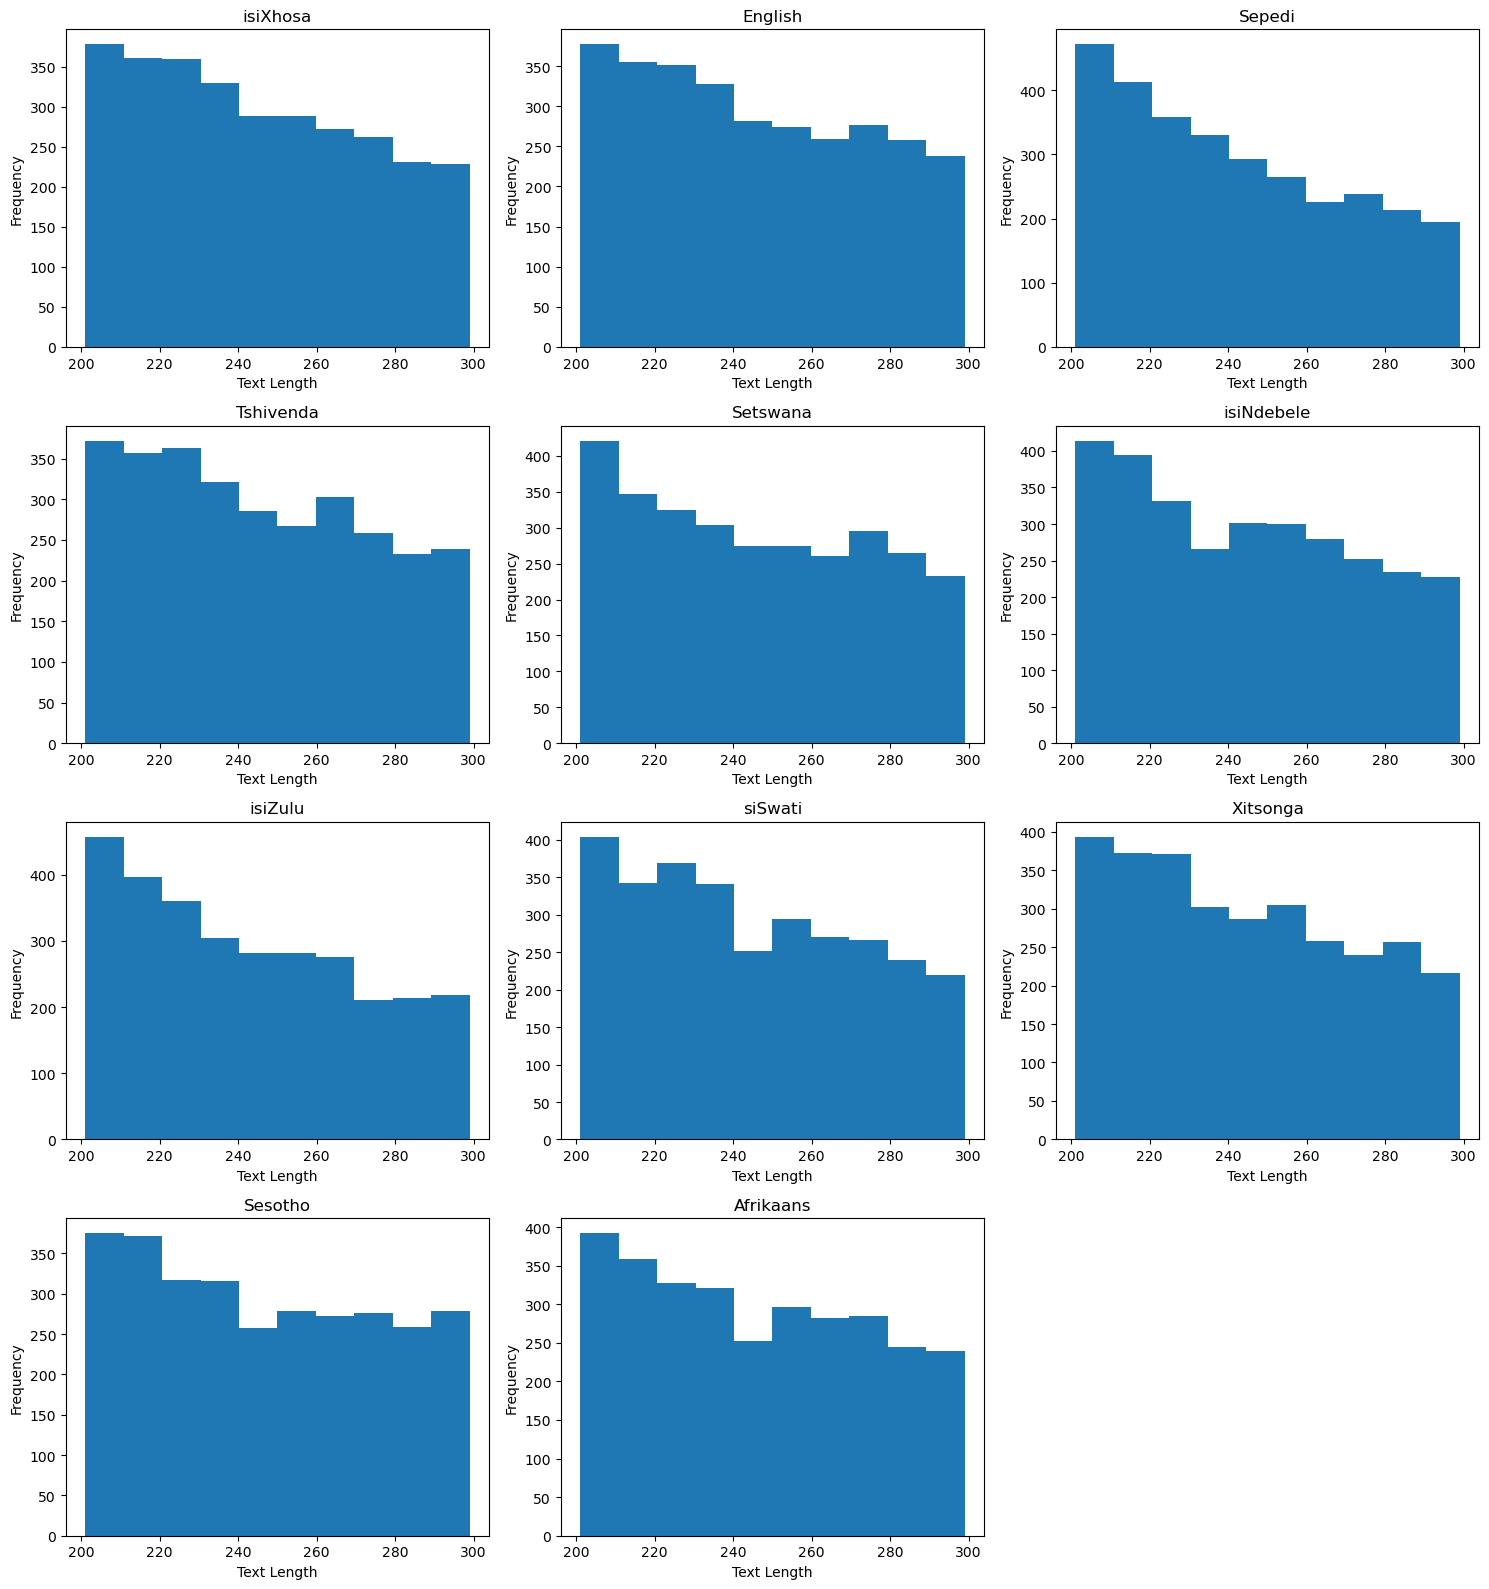

In [19]:
# Creating subplots with three plots in each row
languages = df_eda['language'].unique()
num_plots = len(languages)
num_plots_per_row = 3
num_rows = (num_plots - 1) // num_plots_per_row + 1
fig, axs = plt.subplots(num_rows, num_plots_per_row, figsize=(15, 4*num_rows))

# Plot for each language
for i, lang in enumerate(languages):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    ax = axs[row, col]
    lang_data = df_eda[df_eda['language'] == lang]
    ax.hist(lang_data['text'].apply(len), bins=10)
    ax.set_xlabel('Text Length')
    ax.set_ylabel('Frequency')
    ax.set_title(lang)
    
# Removing empty subplots
if num_plots % num_plots_per_row != 0:
    for i in range(num_plots_per_row - (num_plots % num_plots_per_row)):
        fig.delaxes(axs[num_rows-1, num_plots_per_row-1-i])

#Spacing
plt.tight_layout()


plt.show()

# Modelling

In [22]:
X = df_train['no_stopwords']
y = df_train["lang_id"]
X_test = df_test['no_stopwords']

In [23]:
# Splitting the data into 80% train and 20% validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [24]:
X_train = X_train.apply(lambda x: ' '.join(map(str, x)))
X_val = X_val.apply(lambda x: ' '.join(map(str, x)))
X_test = X_test.apply(lambda x: ' '.join(map(str, x)))

# y_train = y_train.astype(str)
# y_val = y_val.astype(str)


Pipelines are helpful for transforming training, validation, and test data, as well as training our models.In the next section,  a pipeline will be constructed that converts text data into numeric form. Will be using TfidfVectorizer and CountVectorizer to accomplish this conversion.

In [25]:
# Logistic Regression pipeline
logreg_tfidf = Pipeline([("tfidf", TfidfVectorizer()), ("logistic", LogisticRegression()),])
logreg_count = Pipeline([("CountVec",  CountVectorizer()),
                         ("logistic", LogisticRegression()),])

# DecisionTreeClassifier pipeline
tree_tfidf = Pipeline([("tfidf", TfidfVectorizer()), ("tree", DecisionTreeClassifier()),])
tree_count = Pipeline([("CountVec", CountVectorizer()),
                       ("tree", DecisionTreeClassifier()),])

# LinearSVC pipeline
Lsvc_tfidf = Pipeline([("tfidf", TfidfVectorizer()), ("scv", LinearSVC()),])
Lsvc_count = Pipeline([("CountVec", CountVectorizer()),
                       ("svc", LinearSVC()),])

# RandomForestClassifier pipeline
rfc_tfidf = Pipeline([("tfidf", TfidfVectorizer()), ("rfc", RandomForestClassifier())])
rfc_count = Pipeline([("CountVec", CountVectorizer()),
                      ("rfc", RandomForestClassifier()),])

# Ridge model pipeline
ridge_tfidf = Pipeline([("tfidf", TfidfVectorizer()), ("Ridge", RidgeClassifier())])
ridge_count = Pipeline([("CountVec", CountVectorizer()),
                        ("Ridge", RidgeClassifier()),])

# SGD Classifier pipeline
SGD_tfidf = Pipeline([("tfidf", TfidfVectorizer()), ("SGD", SGDClassifier())])
SGD_count = Pipeline([("CountVec", CountVectorizer()),
                      ("SGD", SGDClassifier()),])

# Support Vector Classifier pipeline
svc_tfidf = Pipeline([("tfidf", TfidfVectorizer()), ("SVC", SVC())])
svc_count = Pipeline([("CountVec", CountVectorizer()),
                      ("SVC", SVC()),])

Pipeline(steps=[('CountVec', CountVectorizer()), ('SVC', SVC())])

Pipeline(steps=[('CountVec', CountVectorizer()), ('SVC', SVC())])

Training the models

In [34]:
# training the logistic regression model
logreg_tfidf.fit(X_train, y_train)
logreg_count.fit(X_train, y_train)

# training the decision tree model
tree_tfidf.fit(X_train, y_train)
tree_count.fit(X_train, y_train)

# training the LinearSVC model
Lsvc_tfidf.fit(X_train, y_train)
Lsvc_count.fit(X_train, y_train)

# training the RandomForest model
rfc_tfidf.fit(X_train, y_train)
rfc_count.fit(X_train, y_train)

# training the Ridge model
ridge_tfidf.fit(X_train, y_train)
ridge_count.fit(X_train, y_train)

# training the SGD model
SGD_tfidf.fit(X_train, y_train)
SGD_count.fit(X_train, y_train)

# training the support vector model
svc_tfidf.fit(X_train, y_train)
svc_count.fit(X_train, y_train)



C:\Users\esthe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('CountVec', CountVectorizer()), ('SVC', SVC())])

In [35]:
# calculating average scores for TF-IDF
log_acc = accuracy_score(y_val, logreg_tfidf.predict(X_val))
tree_acc =  accuracy_score(y_val, tree_tfidf.predict(X_val))
lsvc_acc = accuracy_score(y_val, Lsvc_tfidf.predict(X_val))
rfc_acc = accuracy_score(y_val, rfc_tfidf.predict(X_val))
ridge_acc = accuracy_score(y_val, ridge_tfidf.predict(X_val))
sgd_acc = accuracy_score(y_val, SGD_tfidf.predict(X_val))
svc_acc = accuracy_score(y_val, svc_tfidf.predict(X_val))

tfidf_avg_accuracy = round(np.mean([log_acc, tree_acc, lsvc_acc, rfc_acc, ridge_acc, sgd_acc, svc_acc]), 4)

In [29]:
# calculating average scores for CountVec
log_acc = accuracy_score(y_val, logreg_count.predict(X_val))
tree_acc =  accuracy_score(y_val, tree_count.predict(X_val))
lsvc_acc = accuracy_score(y_val, Lsvc_count.predict(X_val))
rfc_acc = accuracy_score(y_val, rfc_count.predict(X_val))
ridge_acc = accuracy_score(y_val, ridge_count.predict(X_val))
sgd_acc = accuracy_score(y_val, SGD_count.predict(X_val))
svc_acc = accuracy_score(y_val, svc_count.predict(X_val))

count_avg_accuracy = round(np.mean([log_acc, tree_acc, lsvc_acc, rfc_acc, ridge_acc, sgd_acc, svc_acc]), 4)

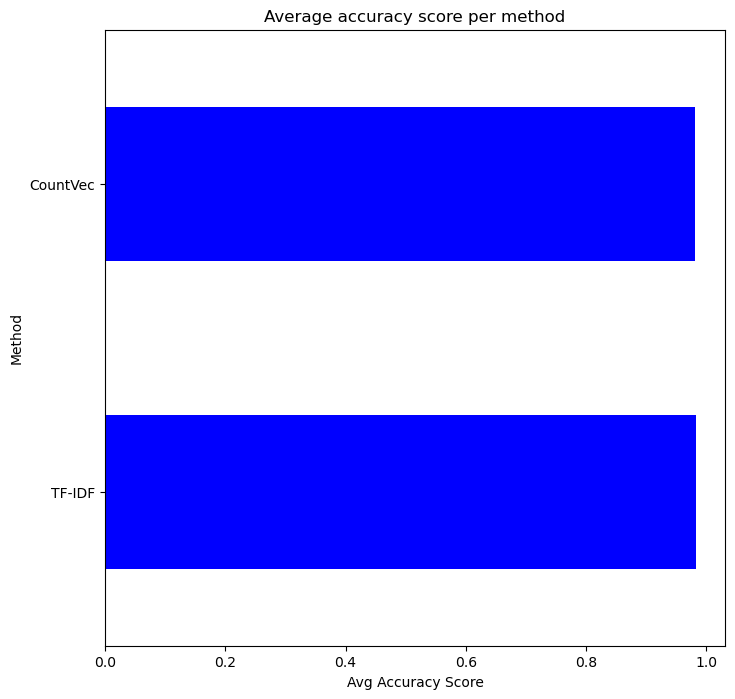

In [30]:
accuracy_dict = {'TF-IDF':[tfidf_avg_accuracy], 'CountVec':[count_avg_accuracy]}
accuracy_df = pd.DataFrame(accuracy_dict)
accuracy_df.T.plot(kind='barh', figsize = (8,8),legend = False, color = 'blue')
plt.xlabel('Avg Accuracy Score')
plt.ylabel('Method')
plt.title('Average accuracy score per method')
# plt.grid()
plt.show()

In [31]:
accuracy_dict

{'TF-IDF': [0.9819], 'CountVec': [0.981]}

 Based on the results, TF -IDF is the best method to use for feature extraction 

In [49]:
logreg_prediction = logreg_tfidf.predict(X_val) # Logistic regression predictions
dectree_prediction = tree_tfidf.predict(X_val) #Decision tree
randomf_prediction = rfc_tfidf.predict(X_val) #Random forest


In [51]:
# Report the confusion matrix
print('\nLogistic Regression\n', confusion_matrix(y_val, logreg_prediction))
print()
print()
# Print a classification report
print('\nLogistic Regression\n', classification_report(y_val, logreg_prediction))
print('\nDecision tree\n', classification_report(y_val, dectree_prediction))
print('\nRandom Forest\n', classification_report(y_val, randomf_prediction))


Logistic Regression
 [[582   0   0   0   0   0   0   0   0   0   1]
 [  0 615   0   0   0   0   0   0   0   0   0]
 [  0   0 575   0   0   0   0   0   0   1   7]
 [  0   0   0 621   1   1   1   0   0   1   0]
 [  0   0   0   0 618   0   0   0   0   0   0]
 [  0   0   0   0   0 581   0   0   0   0   3]
 [  1   0   0   0   0   0 597   0   0   0   0]
 [  0   0   0   0   0   0   0 561   0   0   0]
 [  0   0   0   0   0   0   0   0 634   0   0]
 [  0   0   1   0   0   0   0   0   0 605   3]
 [  0   2   4   0   0   0   0   0   0   0 584]]



Logistic Regression
               precision    recall  f1-score   support

         afr       1.00      1.00      1.00       583
         eng       1.00      1.00      1.00       615
         nbl       0.99      0.99      0.99       583
         nso       1.00      0.99      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       1.00      0.99      1.00       584
         tsn       1.00      1.00      1.00       598
   

LR has the highest accuracy 

In [36]:
y_pred = logreg_count.predict(X_test)
y_pred

array(['tsn', 'nbl', 'eng', ..., 'sot', 'sot', 'zul'], dtype=object)

In [40]:
# # Create copies 
# train = df_train.copy()
# test = df_test.copy()

In [43]:
df_test["lang_id"] = y_pred

In [47]:
df_test[['index','lang_id']]

,index,lang_id
0,1,tsn
1,2,nbl
2,3,eng
3,4,ssw
4,5,eng
...,...,...
5677,5678,eng
5678,5679,nso
5679,5680,sot
5680,5681,sot


In [48]:
df_test[['index','lang_id']].to_csv("hack_model.csv", index = False)